In [2]:
# Modified from: http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/, https://github.com/locuslab/stable_dynamics.git
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

In [5]:
# Consider a simple damped Pendulum, if you are interested, this simulation is capable to simulate a n-link pendulum system by setting N=n.
N=1

# Simulation and Data Generation

In [3]:
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1,
                       friction=0.3):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model

    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass)
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')

    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        # Add damping torque:
        #forces.append((Ai, -1 * friction * u[i] * A.z))

        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)

    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))

    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))
    #odeint

def simpleint(gradient, X, times, args=[]):
    rv = [X]
    for i in range(len(times) - 1):
        X = X + (times[i+1]-times[i]) * gradient(X, times[i+1], *args)
        rv.append(X)
    return rv

In [6]:
t = np.linspace(0, 10, 1000)
selected_data = integrate_pendulum(n=N, times=t)
print(selected_data)

[[ 2.35619449  0.        ]
 [ 2.35584694 -0.06944467]
 [ 2.35480405 -0.13893757]
 ...
 [-0.10524695 -5.77796351]
 [-0.16302339 -5.76483192]
 [-0.22064035 -5.74611078]]


In [7]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

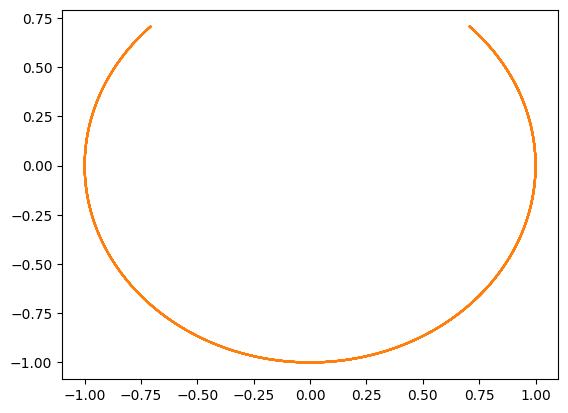

In [8]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

In [9]:
from sympy import Dummy, lambdify, srepr, symbols
from sympy.core.function import AppliedUndef
from sympy.core.sympify import sympify
from sympy.core.power import Pow
from sympy.physics import mechanics
from sympy.physics.vector import Vector
from sympy.printing.printer import Printer

class TorchPrinter(Printer):
    printmethod = "_torchrepr"
    _default_settings = {
        "order": None
    }

    def _print_Add(self, expr, order=None):
        terms = list(map(self._print, self._as_ordered_terms(expr, order=order)))
        def __inner_sum(**kw):
            x = terms[0](**kw)
            for r in terms[1:]:
                v = r(**kw)
                x = torch.add(x, v)
            return x
        return __inner_sum

    def _print_Function(self, expr):
        __FUNCTION_MAP = { "sin": torch.sin, "cos": torch.cos, "tan": torch.tan, "Abs": torch.abs }

        if expr.func.__name__ in __FUNCTION_MAP:
            func = __FUNCTION_MAP[expr.func.__name__]
            args = [self._print(a) for a in expr.args]
            return lambda **kw: func(*(a(**kw) for a in args))
        else:
            key = f"{expr.func.__name__}_{', '.join([str(a) for a in expr.args])}"
            return lambda **kw: kw[key]

    def _print_Half(self, expr):
        return lambda **kw: 0.5

    def _print_Integer(self, expr):
        return lambda **kw: expr.p

    def _print_NaN(self, expr):
        return lambda **kw: float('nan')

    def _print_Mul(self, expr, order=None):
        assert len(expr.args) > 1
        terms = [self._print(a) for a in expr.args]

        def __inner_mul(**kw):
            x = terms[0](**kw)
            for r in terms[1:]:
                x = torch.mul(x, r(**kw))
            return x
        return __inner_mul

    def _print_Rational(self, expr):
        return lambda **kw: expr.p/expr.q

    def _print_Fraction(self, expr):
        numer = self._print(expr.numerator)
        denom = self._print(expr.denominator)
        return lambda **kw: numer(**kw), denom(**kw)

    def _print_Float(self, expr):
        return lambda **kw: float(expr.evalf())

    def _print_Symbol(self, expr):
        d = expr._assumptions.generator
        # print the dummy_index like it was an assumption
        if expr.is_Dummy or d != {}:
            raise NotImplementedError()

        return lambda **kw: kw[expr.name]

    def _print_FracElement(self, frac):
        numer_terms = list(frac.numer.terms())
        assert len(numer_terms) == 1
        #numer_terms.sort(key=frac.field.order, reverse=True)
        denom_terms = list(frac.denom.terms())
        assert len(denom_terms) == 1
        #denom_terms.sort(key=frac.field.order, reverse=True)
        numer = self._print(numer[0])
        denom = self._print(denom[0])
        return lambda *kw: torch.div(numer(*kw), denom(*kw))

    def _print_Expr(self, expr):
        base = self._print(expr.base)
        exp = self._print(expr.exp)
        if isinstance(expr, Pow):
            return lambda **kw: torch.pow(base(**kw), exp(**kw))

        raise NotImplementedError(f"No implementation of Expr {expr}")
        # return lambda **kw: kw[expr.name]

def sympy2torch(expr):
    return TorchPrinter()._print(expr)

In [12]:
def pendulum_energy(n=1, lengths=1, masses=1, include_gpe=True, include_ke=True):
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass)
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')

    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    Origin = P
    P.set_vel(A, 0)

    gravity_direction = -A.x

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []

    gpe = []
    ke = []

    cartVel = 0.0
    cartPos = 0.0

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Calculate the cartesian position and velocity:
        # cartPos += l[i] * q[i]
        pos = Pi.pos_from(Origin)

        ke.append(1/n * Pai.kinetic_energy(A))
        gpe.append(m[i] * g * (Pi.pos_from(Origin) & gravity_direction))

        P = Pi

    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))

    # create functions for numerical calculation
    total_energy = 0
    if include_gpe:
        total_energy += (sum(gpe)).subs(zip(parameters, parameter_vals))
    if include_ke:
        total_energy += (sum( ke)).subs(zip(parameters, parameter_vals))

    total_energy_func = sympy2torch(total_energy)

    minimum_energy = total_energy_func(**fixvalue(n, torch.tensor([[0.]*2*n]))).detach()
    return lambda inp: (total_energy_func(**fixvalue(n, inp)) - minimum_energy.to(inp)).unsqueeze(1)

def fixvalue(n, value):
    keys = [f"q{i}_t" for i in range(n)] + [f"u{i}_t" for i in range(n)]
    rv = {}
    for i in range(2*n):
        if isinstance(value, list):
            rv[keys[i]] = value[i]
        else:
            rv[keys[i]] = value[:,i]
    return rv

In [13]:
def pendulum_gradient(n, lengths=None, masses=1, friction=0.3):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model

    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass)
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')

    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        # Add damping torque:
        forces.append((Ai, -1 * friction * u[i] * A.z))

        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)

    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, *a, **kw):
        squeeze = False
        if len(y.shape) == 1:
            squeeze = True
            y = np.expand_dims(y, 0)
        rv = np.zeros_like(y)

        for i in range(y.shape[0]):
            # Assume in rad, rad/s:
            #y = np.concatenate([np.broadcast_to(initial_positions, n), np.broadcast_to(initial_velocities, n)])

            vals = np.concatenate((y[i,:], parameter_vals))
            sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
            rv[i,:] = np.array(sol).T[0]

        if squeeze:
            return rv[0,...]
        return rv

    # ODE integration
    return gradient

def _redim(inp):
    vec = np.array(inp)
    # Wrap all dimensions:
    n = vec.shape[1] // 2
    assert vec.shape[1] == n*2

    # Get angular positions:
    pos = vec[:,:n]
    l = 100

    if np.any(pos < -np.pi):
        # In multiples of 2pi
        adj, _ = np.modf((pos[pos < -np.pi] + np.pi) / (2*np.pi))
        # Scale it back
        pos[pos < -np.pi] = (adj * 2*np.pi) + np.pi
        assert not np.any(pos < -np.pi)

    if np.any(pos >= np.pi):
        # In multiples of 2pi
        adj, _ = np.modf((pos[pos >= np.pi] - np.pi) / (2*np.pi))
        # Scale it back
        pos[pos >= np.pi] = (adj * 2*np.pi) - np.pi
        assert not np.any(pos >= np.pi)

    vec[:,:n] = pos
    return vec

In [14]:
# Generate the dataset, X is the input, the labels are the corresponding gradients.
def f_true(x):
        g_l = 9.81
        b = 0.3
        return np.array([x[:,1], -b*x[:,1] + g_l*np.sin(x[:,0]-np.pi)]).T

gfunc = pendulum_gradient(1)
X_data = (np.random.rand(10000, 2).astype(np.float32) - 0.5) * 2 * np.pi # Pick values in range [-pi, pi] radians, radians/sec

test = gfunc(X_data)
ref = f_true(X_data)

differences = sorted(np.sum((test - ref) ** 2, axis=1))[-8:]
print(differences)
assert differences[-1] < 1e-8

[np.float32(1.0359713e-11), np.float32(1.0359713e-11), np.float32(1.0359713e-11), np.float32(1.0359713e-11), np.float32(1.114131e-11), np.float32(1.114131e-11), np.float32(1.114131e-11), np.float32(1.114131e-11)]


In [15]:
# Save the dataset
np.savez('data.npz',X=X_data,Y=test)


# Neural Networks for learn the dynamics

In [17]:
#Simple Neural Network: We consider f: 2n-100-100-2n
import torch
from torch import nn
model_simple = nn.Sequential(
    nn.Linear(2*N, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 2*N)
)
loss_ = nn.MSELoss()
loss_simple = lambda Ypred, Yactual, X, **kw: loss_(Ypred, Yactual)

In [18]:
import torch.nn.functional as F
import math
VERIFY = False
V_SCALE = 0.01

global V_WRAP, SCALE_FX
V_WRAP = False
SCALE_FX = False
SMOOTH_V = 6

class Dynamics(nn.Module):
    def __init__(self, fhat, V, alpha=0.01,no_proj=False):
        super().__init__()
        self.fhat = fhat
        self.V = V
        self.alpha = alpha
        self.no_proj = no_proj

    def forward(self, x):
        fx = self.fhat(x)
        if SCALE_FX:
            fx = fx / fx.norm(p=2, dim=1, keepdim=True).clamp(min=1.0)

        Vx = self.V(x)
        gV = torch.autograd.grad([a for a in Vx], [x], create_graph=True, only_inputs=True)[0]
        if self.no_proj:
          rv = fx
        else:
          rv = fx - gV * (F.relu((gV*fx).sum(dim=1) + self.alpha*Vx[:,0])/(gV**2).sum(dim=1))[:,None]

        if VERIFY:
            # Verify that rv has no positive component along gV.
            # This helps us catch:
            #   (1) numeric error in the symbolic gradient calculation, and
            #   (2) Violation of the Lyapunov function when Euler integration is used.
            verify = (gV * rv).sum(dim=1)
            num_violation = len([v for v in verify if v > 0]) # (1)
            new_V = self.V(x + V_SCALE * rv)
            if (new_V > Vx).any(): # (2)
                err = sorted([v for v in (new_V - Vx).detach().cpu().numpy().ravel() if v > 0], reverse=True)

        return rv

class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0]))
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]



class ReHU(nn.Module):
    """ Rectified Huber unit"""
    def __init__(self, d):
        super().__init__()
        self.a = 1/d
        self.b = -d/2

    def forward(self, x):
        return torch.max(torch.clamp(torch.sign(x)*self.a/2*x**2,min=0,max=-self.b),x+self.b)

class MakePSD(nn.Module):
    def __init__(self, f, n, eps=0.01, d=1.0):
        super().__init__()
        self.f = f
        self.zero = torch.nn.Parameter(f(torch.zeros(1,n)), requires_grad=False)
        self.eps = eps
        self.d = d
        self.rehu = ReHU(self.d)

    def forward(self, x):
        smoothed_output = self.rehu(self.f(x) - self.zero)
        quadratic_under = self.eps*(x**2).sum(1,keepdim=True)
        return smoothed_output + quadratic_under

def loss_stable(model, Ypred, Yactual, X, no_proj=False):
    # Force smoothness in V:
    # penalty for new_V being larget than old V:
    Vloss = torch.tensor(0)
    if SMOOTH_V:
        V = model.V
        # Successor to X:

        if no_proj:
          succ_X = (X + V_SCALE * Ypred)
        else:
          succ_X = (X + V_SCALE * Yactual).detach()
        if V_WRAP:
            while torch.any(succ_X < -math.pi):
                succ_X[succ_X < -math.pi] = succ_X[succ_X < -math.pi] + 2 * math.pi
            while torch.any(succ_X >= math.pi):
                succ_X[succ_X >= math.pi] = succ_X[succ_X >= math.pi] - 2 * math.pi
            succ_X.requires_grad_()

        Vloss = (V(succ_X) - V(X)).clamp(min=0).mean()

    l2loss = ((Ypred - Yactual)**2).mean() #L2 loss

    return (l2loss + SMOOTH_V * Vloss, l2loss, Vloss)


In [19]:
fhat = nn.Sequential(
    nn.Linear(2*N, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 2*N)
)
projfn_eps = 5
V = MakePSD(ICNN([2*N, 60, 60, 1], activation=ReHU(float(7))), 2*N, eps=projfn_eps, d=1.0)
model_stable = Dynamics(fhat, V, alpha=0.001)

# With two models, now we train the neural networks to learn the dynamics

In [20]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [24]:
def to_variable(X, cuda=True):
    if isinstance(X, (tuple, list)):
        return tuple(to_variable(x) for x in X)
    else:
        X = Variable(X)
        if cuda:
            return X.cuda().requires_grad_()
        return X.requires_grad_()

def runbatch(model, loss, batch, no_proj=False):
    X, Yactual = batch
    X = to_variable(X, cuda=False)#torch.cuda.is_available())
    Yactual = to_variable(Yactual, cuda=False)#torch.cuda.is_available())

    Ypred = model(X)
    return loss(model, Ypred, Yactual, X, no_proj), Ypred


epochs = 1000
batch_size = 2000
learning_rate = 0.01
# To minimize installation, we do not use summary writter here
loss_record = []
dataset = torch.utils.data.TensorDataset(torch.tensor(X_data), torch.tensor(test))
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = model_stable
loss = loss_stable

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)  # Decays the learning rate by a factor of 0.1 every 100 epochs

for epoch in range(1, epochs + 1):
  loss_parts = []
  model.train()
  for data in train_dataloader:
    optimizer.zero_grad()
    loss, _ = runbatch(model, loss_stable, data)
    loss_parts.append(np.array([l.cpu().item() for l in loss]))

    optim_loss = loss[0] if isinstance(loss, (tuple, list)) else loss
    optim_loss.backward()
    optimizer.step()
    epoch_loss = sum(loss_parts) / len(dataset)

  print(f'Epoch {epoch}, loss: {epoch_loss}')
  loss_record.append(epoch_loss)
  scheduler.step()




Epoch 1, loss: [0.0103976  0.00927724 0.00018673]
Epoch 2, loss: [0.00709248 0.00599415 0.00018305]
Epoch 3, loss: [0.00592673 0.00484363 0.00018052]
Epoch 4, loss: [0.00553629 0.00446613 0.00017836]
Epoch 5, loss: [0.00488416 0.00382609 0.00017634]
Epoch 6, loss: [0.00441237 0.00336534 0.0001745 ]
Epoch 7, loss: [0.00381438 0.00278015 0.00017237]
Epoch 8, loss: [0.0032166  0.00219852 0.00016968]
Epoch 9, loss: [0.00272292 0.00172574 0.0001662 ]
Epoch 10, loss: [0.00235515 0.00138369 0.00016191]
Epoch 11, loss: [0.00206812 0.00112707 0.00015684]
Epoch 12, loss: [0.00184334 0.00093619 0.00015119]
Epoch 13, loss: [0.0016409  0.00077207 0.00014481]
Epoch 14, loss: [0.00147123 0.00064307 0.00013803]
Epoch 15, loss: [0.00131088 0.00052436 0.00013109]
Epoch 16, loss: [0.0011661  0.00042111 0.00012417]
Epoch 17, loss: [0.00104584 0.00033847 0.0001179 ]
Epoch 18, loss: [0.00099125 0.00031478 0.00011275]
Epoch 19, loss: [0.00088049 0.00023454 0.00010766]
Epoch 20, loss: [0.00081694 0.00019519 0

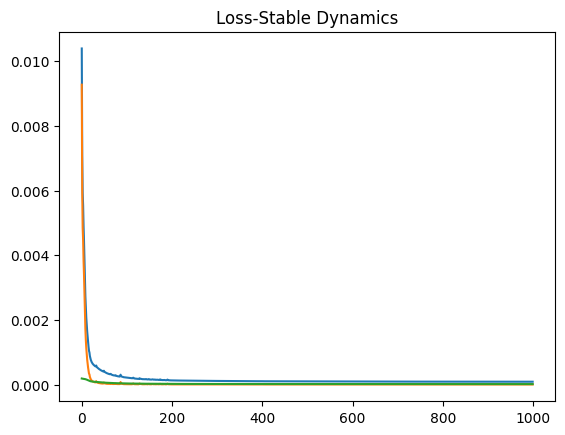

In [25]:
from matplotlib import pyplot as plt
plt.plot(loss_record)
plt.title('Loss-Stable Dynamics')
plt.show()

In [26]:
fhat = nn.Sequential(
    nn.Linear(2*N, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 2*N)
)
projfn_eps = 5
V = MakePSD(ICNN([2*N, 60, 60, 1], activation=ReHU(float(7))), 2*N, eps=projfn_eps, d=1.0)
model_stable_no_proj = Dynamics(fhat, V, alpha=0.01, no_proj=True)

# Previous model is enforced by projection, now we only use sofy penalty

In [28]:
loss_record = []

learning_rate = 0.01
optimizer = optim.Adam(model_stable_no_proj.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

for epoch in range(1, epochs + 1):
  loss_parts = []
  model_stable_no_proj.train()
  for data in train_dataloader:
    optimizer.zero_grad()
    loss, _ = runbatch(model_stable_no_proj, loss_stable, data, True)
    loss_parts.append(np.array([l.cpu().item() for l in loss]))

    optim_loss = loss[0] if isinstance(loss, (tuple, list)) else loss
    optim_loss.backward()
    optimizer.step()
    epoch_loss = sum(loss_parts) / len(dataset)
  print(f'Epoch {epoch}, loss: {epoch_loss}')
  loss_record.append(epoch_loss)
  scheduler.step()

Epoch 1, loss: [0.00363108 0.00268784 0.00015721]
Epoch 2, loss: [2.21224322e-03 1.77630758e-03 7.26559460e-05]
Epoch 3, loss: [1.41987975e-03 9.93181813e-04 7.11163238e-05]
Epoch 4, loss: [9.56459272e-04 4.24976793e-04 8.85804102e-05]
Epoch 5, loss: [8.57571983e-04 4.61322451e-04 6.60415895e-05]
Epoch 6, loss: [6.87619007e-04 3.82911628e-04 5.07845625e-05]
Epoch 7, loss: [6.30923808e-04 1.95479247e-04 7.25740939e-05]
Epoch 8, loss: [5.72437215e-04 2.55327842e-04 5.28515622e-05]
Epoch 9, loss: [5.36616600e-04 1.60350597e-04 6.27109997e-05]
Epoch 10, loss: [5.14256346e-04 1.42598179e-04 6.19430281e-05]
Epoch 11, loss: [5.02861995e-04 1.37765047e-04 6.08494900e-05]
Epoch 12, loss: [4.94149375e-04 1.57169411e-04 5.61633259e-05]
Epoch 13, loss: [4.85000587e-04 1.27043548e-04 5.96595049e-05]
Epoch 14, loss: [4.80191964e-04 1.28722925e-04 5.85781753e-05]
Epoch 15, loss: [4.76271927e-04 1.36177802e-04 5.66823520e-05]
Epoch 16, loss: [4.73399603e-04 1.22330372e-04 5.85115381e-05]
Epoch 17, los

# This is a simple Neural Network

In [34]:
optimizer = optim.Adam(model_simple.parameters(), lr=learning_rate)
loss_record_simple = []
for epoch in range(1, epochs + 1):
  loss_parts = []
  model_simple.train()
  for data in train_dataloader:
    optimizer.zero_grad()
    loss, _ = runbatch(model_simple, loss_simple, data)
    loss_parts.append(np.array([l.cpu().item() for l in [loss]]))

    optim_loss = loss[0] if isinstance(loss, (tuple, list)) else loss
    optim_loss.backward()
    optimizer.step()
    epoch_loss = sum(loss_parts) / len(dataset)
  print(f'Epoch {epoch}, loss: {epoch_loss}')
  loss_record_simple.append(epoch_loss)

TypeError: <lambda>() takes 3 positional arguments but 5 were given

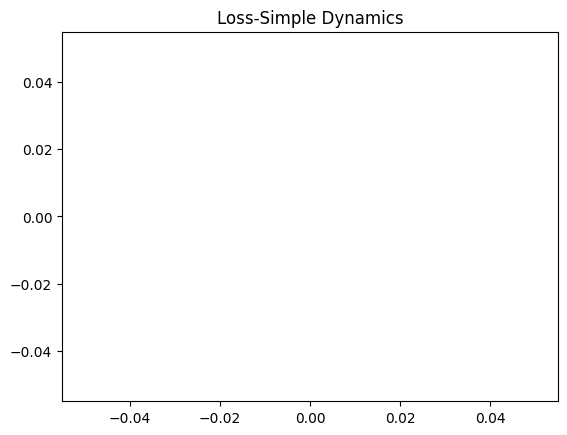

In [33]:
plt.plot(loss_record_simple)
plt.title('Loss-Simple Dynamics')
plt.show()

For the 1-link pendulum (damped pendulum), the simple NN can also do a great job. But for n-link, it will suffer.

# With the trained models, now we can test their performance

In [35]:
#timestep
h = 0.01
physics = pendulum_gradient(N)

energy = pendulum_energy(N)
n = N
number = 100
steps = 1000
X_init = np.zeros((number, 2 * n)).astype(np.float32)
X_init[:,:] = (np.random.rand(number, 2*n).astype(np.float32) - 0.5) * np.pi/4 # Pick values in range [-pi/8, pi/8] radians, radians/sec
X_phy = np.zeros((steps, *X_init.shape), dtype=np.float32)
X_phy[0,...] = X_init
for i in range(1, steps):
    k1 = h * physics(X_phy[i-1,...])
    k2 = h * physics(X_phy[i-1,...] + k1/2)
    k3 = h * physics(X_phy[i-1,...] + k2/2)
    k4 = h * physics(X_phy[i-1,...] + k3)
    X_phy[i,...] = X_phy[i-1,...] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    assert not np.any(np.isnan(X_phy[i,...]))

In [37]:
model_simple.eval()
X_nn = to_variable(torch.tensor(X_phy[0,:,:]), cuda=False) #torch.cuda.is_available())
log_y = []
errors = np.zeros((steps,))
for i in range(1, steps):
    X_nn.requires_grad = True
    k1 = h * model_simple(X_nn)
    k1 = k1.detach()
    k2 = h * model_simple(X_nn + k1/2)
    k2 = k2.detach()
    k3 = h * model_simple(X_nn + k2/2)
    k3 = k3.detach()
    k4 = h * model_simple(X_nn + k3)
    k4 = k4.detach()
    X_nn = X_nn + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    X_nn = X_nn.detach()

    y = X_nn.cpu().numpy()
    log_y.append(y)

    vel_error = np.sum((X_phy[i,:,n:] - y[:,n:])**2)
    ang_error = (X_phy[i,:,:n] - y[:,:n])
    while np.any(ang_error >= np.pi):
        ang_error[ang_error >= np.pi] -= 2*np.pi
    while np.any(ang_error < -np.pi):
        ang_error[ang_error < -np.pi] += 2*np.pi

    ang_error = np.sum(ang_error**2)
    errors[i] = (vel_error + ang_error)


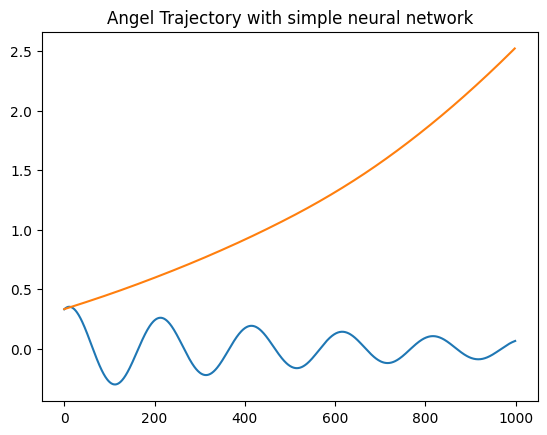

In [38]:
log_y = np.array(log_y)
plt.plot(X_phy[:,0,0])
plt.plot(log_y[:,0,0])
plt.title('Angel Trajectory with simple neural network')
plt.show()

In [40]:
model.eval()
X_nn = to_variable(torch.tensor(X_phy[0,:,:]), cuda=False)#torch.cuda.is_available())
log_y = []
errors = np.zeros((steps,))
for i in range(1, steps):
    X_nn.requires_grad = True
    k1 = h * model(X_nn)
    k1 = k1.detach()
    k2 = h * model(X_nn + k1/2)
    k2 = k2.detach()
    k3 = h * model(X_nn + k2/2)
    k3 = k3.detach()
    k4 = h * model(X_nn + k3)
    k4 = k4.detach()
    X_nn = X_nn + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    X_nn = X_nn.detach()

    y = X_nn.cpu().numpy()
    log_y.append(y)

    vel_error = np.sum((X_phy[i,:,n:] - y[:,n:])**2)
    ang_error = (X_phy[i,:,:n] - y[:,:n])
    while np.any(ang_error >= np.pi):
        ang_error[ang_error >= np.pi] -= 2*np.pi
    while np.any(ang_error < -np.pi):
        ang_error[ang_error < -np.pi] += 2*np.pi

    ang_error = np.sum(ang_error**2)
    errors[i] = (vel_error + ang_error)



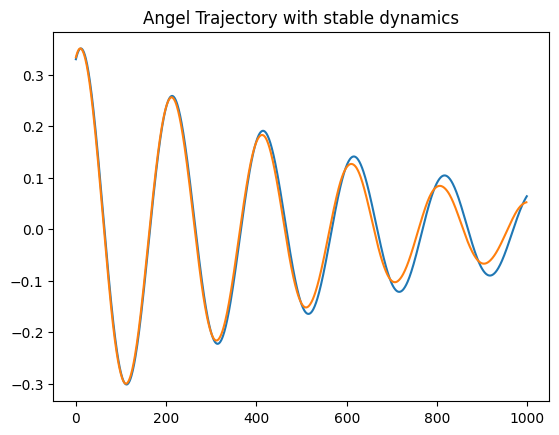

In [41]:
log_y = np.array(log_y)
plt.plot(X_phy[:,0,0])
plt.plot(log_y[:,0,0])
plt.title('Angel Trajectory with stable dynamics')
plt.show()

In [42]:
model.V(torch.tensor([[1,1]], dtype=torch.float32))

tensor([[60.8117]], grad_fn=<AddBackward0>)

In [43]:
model.fhat(torch.tensor([[1,1]], dtype=torch.float32)).shape

torch.Size([1, 2])

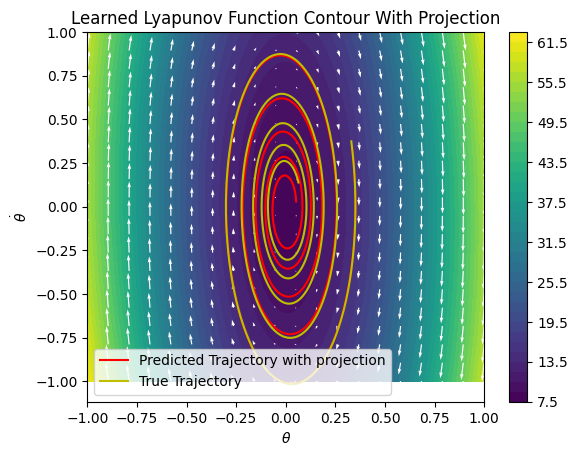

In [44]:
log_y = np.array(log_y)
def plot_lyapunov_contour(lyapunov_function, x_range, y_range):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[lyapunov_function(torch.tensor([[xi, yi]], dtype=torch.float32)).item() for xi, yi in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
    xx = np.linspace(x_range[0], x_range[1], 20)
    yy = np.linspace(y_range[0], y_range[1], 20)
    XX, YY = np.meshgrid(xx, yy)
    U, V = np.array([[model.fhat(torch.tensor([[xi, yi]], dtype=torch.float32)).detach().numpy() for xi, yi in zip(x_row, y_row)] for x_row, y_row in zip(XX, YY)]).squeeze().transpose(2, 0, 1)

    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar()
    plt.quiver(XX, YY, U, V, color='white')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    return X,Y,Z
X,Y,Z=plot_lyapunov_contour(model.V, [-1, 1], [-1, 1])
id = 0
plt.plot(log_y[:,id,0],log_y[:,id,1], 'r-', label='Predicted Trajectory with projection')
plt.plot(X_phy[:,id,0],X_phy[:,id,1], 'y-', label='True Trajectory')
plt.title('Learned Lyapunov Function Contour With Projection')
plt.legend()

In [ ]:
model_stable_no_proj.eval()
X_nn_no_proj = to_variable(torch.tensor(X_phy[0,:,:]), cuda=False)#torch.cuda.is_available())
log_y_no_proj = []
errors_no_proj = np.zeros((steps,))
for i in range(1, steps):
    X_nn_no_proj.requires_grad = True
    k1 = h * model_stable_no_proj(X_nn_no_proj)
    k1 = k1.detach()
    k2 = h * model_stable_no_proj(X_nn_no_proj + k1/2)
    k2 = k2.detach()
    k3 = h * model_stable_no_proj(X_nn_no_proj + k2/2)
    k3 = k3.detach()
    k4 = h * model_stable_no_proj(X_nn_no_proj + k3)
    k4 = k4.detach()
    X_nn_no_proj = X_nn_no_proj + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    X_nn_no_proj = X_nn_no_proj.detach()

    y_no_proj = X_nn_no_proj.cpu().numpy()
    log_y_no_proj.append(y_no_proj)

    vel_error_no_proj = np.sum((X_phy[i,:,n:] - y_no_proj[:,n:])**2)
    ang_error_no_proj = (X_phy[i,:,:n] - y_no_proj[:,:n])
    while np.any(ang_error_no_proj >= np.pi):
        ang_error_no_proj[ang_error_no_proj >= np.pi] -= 2*np.pi
    while np.any(ang_error_no_proj < -np.pi):
        ang_error_no_proj[ang_error_no_proj < -np.pi] += 2*np.pi

    ang_error_no_proj = np.sum(ang_error_no_proj**2)
    errors_no_proj[i] = (vel_error_no_proj + ang_error_no_proj)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

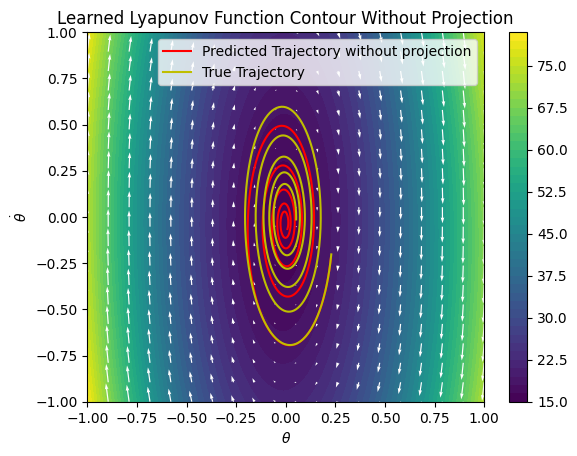

In [30]:
X,Y,Z=plot_lyapunov_contour(model_stable_no_proj.V, [-1, 1], [-1, 1])
id = 0
log_y_no_proj = np.array(log_y_no_proj)
plt.plot(log_y_no_proj[:,id,0],log_y_no_proj[:,id,1], 'r-', label='Predicted Trajectory without projection')
plt.plot(X_phy[:,id,0],X_phy[:,id,1], 'y-', label='True Trajectory')
plt.title('Learned Lyapunov Function Contour Without Projection')
plt.legend()